# BP神经网络预测

In [1]:
# 导入包
import torch
from torch import nn
import numpy as np
import torch.nn.functional as Fun
import scipy.io as scio
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

# 读取数据

In [2]:
file_name = "data.mat"
data = scio.loadmat(file_name)
x = data.get("PPP")
x = x.T
y = data.get("TTT")
y = y[0]

In [3]:
print("x.shape :", x.shape, " y.shape: ", y.shape)

x.shape : (205, 4)  y.shape:  (205,)


In [4]:
print(x[0:5])

[[ 9.53333333e+01  7.73333333e+01  3.67333333e+01 -7.13518730e-01]
 [ 1.04333333e+02  5.80000000e+01  3.32000000e+01 -6.43337135e-01]
 [ 9.50000000e+01  7.30000000e+01  3.55000000e+01  9.59860109e-02]
 [ 9.40000000e+01  7.10000000e+01  3.51000000e+01  3.01645487e-01]
 [ 1.03000000e+02  6.73333333e+01  3.64666667e+01 -4.38108606e-02]]


In [5]:
print(y[0:5])

[4.6 6.6 9.1 5.1 5.3]


In [6]:
x = (x-x.mean(0)) / x.std(0)
y = (y-y.mean()) / y.std() 

In [7]:
print(x[0:5])

[[-0.52147321  0.76319887  1.33865611 -1.34304263]
 [ 0.58313996 -1.32768467 -2.03085591 -1.18108895]
 [-0.56238481  0.29455256  0.16250569  0.52500084]
 [-0.6851196   0.07825426 -0.2189485   0.99958835]
 [ 0.41949356 -0.31829262  1.08435332  0.20240034]]


In [8]:
print(y[0:5])

[-1.0952285   0.38774272  2.24145674 -0.72448569 -0.57618857]


In [9]:
def split_train_test(X, y, test_ratio):
    shuffled_indices = np.random.permutation(len(y))
    test_set_size = int(len(y) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return X[train_indices,:], y[train_indices], X[test_indices,:], y[test_indices]

In [10]:
train_x, train_y, test_x, test_y = split_train_test(x, y, 0.2)

In [11]:
train_x.shape, train_y.shape,test_x.shape, test_y.shape

((164, 4), (164,), (41, 4), (41,))

## 将numy转换为tensor

In [12]:
train_x = torch.tensor(train_x, dtype = torch.float)
train_y = torch.tensor(train_y, dtype = torch.float)
test_x = torch.tensor(test_x, dtype = torch.float)
test_y = torch.tensor(test_y, dtype = torch.float)

dataset = torch.utils.data.TensorDataset(train_x, train_y)
train_iter = torch.utils.data.DataLoader(dataset, 5 ,shuffle=True)

## 定义BP神经网络

In [13]:
class Net(torch.nn.Module):
    def __init__(self, n_features, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_features, n_hidden)
        self.out = torch.nn.Linear(n_hidden, n_output)

    def forward(self, X_data):
        x = self.hidden(X_data)
        x_relu = Fun.relu(x)
        predict_y = self.out(x_relu)
        return predict_y

In [14]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss(clipped_preds.log(),labels.log()).mean())
    return rmse.item()

In [15]:
net = Net(4, 9, 1)
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
loss = torch.nn.MSELoss()
for param in net.parameters():
    torch.nn.init.normal_(param, mean=0, std=0.01)
print(net)

Net(
  (hidden): Linear(in_features=4, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=1, bias=True)
)


In [17]:
train_ls, test_ls = [], []
for i in range(500):
    for x, y in train_iter:
        out = net(x)
        l = loss(out, train_y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    train_ls.append(l)
    if test_labels is not None:
        test_ls.append(log_rmse(net, test_x, test_y))

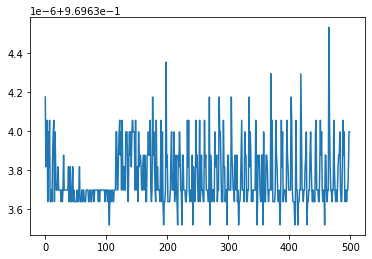

In [16]:
plt.plot(train_ls)
plt.show()

In [17]:
predict_y = net(train_x)
predict_y[0:5]

tensor([[-0.0314],
        [-0.0314],
        [-0.0314],
        [-0.0314],
        [-0.0314]], grad_fn=<SliceBackward>)

In [18]:
for parameters in net.parameters():
    print(parameters)

Parameter containing:
tensor([[-1.8592e-02, -2.3290e-02,  1.5194e-02, -1.4898e-02],
        [ 2.4456e-03,  9.2255e-03, -6.9119e-03, -1.7669e-03],
        [ 1.3494e-03,  4.1730e-03, -3.1080e-03, -4.2914e-03],
        [ 1.9919e-02,  8.0037e-03,  2.2451e-02, -2.8093e-03],
        [ 2.1030e-03, -3.0169e-03,  5.0174e-03,  3.0446e-03],
        [ 3.4817e-03,  5.8086e-03, -8.7256e-05,  4.8582e-03],
        [ 9.5533e-03, -6.4686e-03,  7.4747e-03, -1.5820e-03],
        [ 1.9888e-02, -6.2338e-03, -7.5625e-03,  1.3952e-02],
        [ 1.4079e-02, -7.7126e-03, -1.3493e-02,  8.0433e-03]],
       requires_grad=True)
Parameter containing:
tensor([-0.0726, -0.0297, -0.0125, -0.0705, -0.0122, -0.0336, -0.0486, -0.0665,
        -0.0494], requires_grad=True)
Parameter containing:
tensor([[-0.0062,  0.0081,  0.0007, -0.0180,  0.0010, -0.0136,  0.0250, -0.0148,
          0.0052]], requires_grad=True)
Parameter containing:
tensor([-0.0314], requires_grad=True)


In [19]:
# clarke网格误差分析
def clarke(y,y_predicted):
    """
    clarke网格分析

    total, percentage = clarke(y, yp)
    
    INPUTS:
    y       Reference values(血糖浓度参考值)
    yp      Predicted/estimated values(血糖预测值)
    
    OUTPUTS:

    """
    # 设置坐标轴范围和坐标轴名称
    plt.xlim(0, 400*0.0556)
    plt.ylim(0, 400*0.0556)
    plt.xlabel('Reference values of Blood Glucose(mmol/L)')
    plt.ylabel('Predicted values of Blood Glucose(mmol/L)')
    # 获取数据长度
    n = len(y)
    # 散点图绘制数据
    plt.scatter(y, y_predicted, s=15)
    # 绘制网线
    # 上半区网线
    plt.plot([0,400*0.0556],[0,400*0.0556],linestyle=':',c='k') 
    plt.plot([0,175*0.0556/3],[70*0.0556,70*0.0556],c='k',linewidth=1)
    plt.plot([175*0.0556/3,400*0.0556/1.2],[70*0.0556,400*0.0556],c='k',linewidth=1)
    plt.plot([70*0.0556,70*0.0556],[84*0.0556,400*0.0556],c='k', linewidth=1)
    plt.plot([0,70*0.0556],[180*0.0556,180*0.0556],c='k',linewidth=1)
    plt.plot([70*0.0556,290*0.0556],[180*0.0556,400*0.0556],c='k', linewidth=1)
    # 下半区网线绘制
    plt.plot([70*0.0556,70*0.0556],[0,56*0.0556],c='k',linewidth=1)
    plt.plot([70*0.0556,400*0.0556],[56*0.0556,320*0.0556],c='k',linewidth=1)
    plt.plot([180*0.0556,180*0.0556],[0,70*0.0556],c='k',linewidth=1)
    plt.plot([180*0.0556,400*0.0556],[70*0.0556,70*0.0556],c='k',linewidth=1)
    plt.plot([240*0.0556,240*0.0556],[70*0.0556,180*0.0556],c='k',linewidth=1)
    plt.plot([240*0.0556,400*0.0556],[180*0.0556,180*0.0556],c='k',linewidth=1)
    plt.plot([130*0.0556,180*0.0556],[0,70*0.0556],c='k',linewidth=1)
    
    # 绘制区域标签A,B,C,D,E
    plt.text(30*0.0556,20*0.0556,'A',fontsize=9);
    plt.text(30*0.0556,150*0.0556,'D',fontsize=9);
    plt.text(30*0.0556,380*0.0556,'E',fontsize=9);
    plt.text(150*0.0556,380*0.0556,'C',fontsize=9);
    plt.text(160*0.0556,20*0.0556,'C',fontsize=9);
    plt.text(380*0.0556,20*0.0556,'E',fontsize=9);
    plt.text(380*0.0556,120*0.0556,'D',fontsize=9);
    plt.text(380*0.0556,260*0.0556,'B',fontsize=9);
    plt.text(280*0.0556,380*0.0556,'B',fontsize=9);

    # 计算数据
    total = np.zeros(5)
    # A区域
    for i in range(0,n):
        if (y[i] <= 70*0.0556 and y_predicted[i] <= 70*0.0556) or (y_predicted[i] <= 1.2*y[i] and y_predicted[i] >= 0.8*y[i]): 
            total[0] = total[0] + 1
        else:
            # E区域
            if(y[i] >= 180*0.0556 and y_predicted[i] <= 70*0.0556) or (y[i] <= 70*0.0556 and y_predicted[i] >= 180*0.0556):
                total[4] = total[4] + 1
            else:
                # 区域C
                if (y[i] >= 70*0.0556 and y[i] <= 290*0.0556) and (y_predicted[i] >= y[i] + 110*0.0556) or (y[i] >= 130*0.0556 and y[i] <= 180*0.0556) and (y_predicted[i] <= (7/5)*y[i] - 182*0.0556):
                    total[2] = total[2] + 1
                else:
                    # 区域D
                    if (y[i] >= 240*0.0556) and (y_predicted[i] >= 70*0.0556) and (y_predicted[i] <= 180*0.0556) or (y[i] <= 175*0.0556/3 and y_predicted[i] <= 180*0.0556) and (y_predicted[i] >= 70*0.0556) or (y[i] >= 175*0.0556/3 and y[i] <= 70*0.0556) and (y_predicted[i] >= (6/5)*y[i]):
                        total[3] = total[3] + 1
                    else:
                        # 区域B
                        total[1] = total[1] + 1

    percentage = (total/n)*100
    plt.show()
    return total, percentage

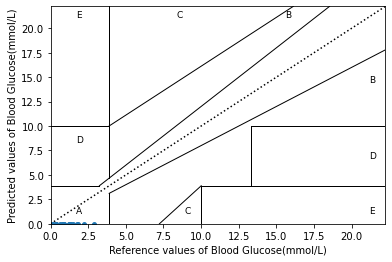

In [20]:
predict_y = net(test_x).detach().numpy()
test_y = (test_y).numpy()
total, percentage = clarke(test_y, predict_y)

In [21]:
print(test_y)

[ 1.2033769  -0.94693136  0.16529703 -1.0210799   0.01699991 -0.20544577
 -0.27959433  0.38774273  2.2414567  -0.94693136  0.6101884   0.9067826
  1.2775254  -0.57618856 -0.57618856  1.4999712   0.8326341   0.38774273
 -0.57618856 -0.65033716 -0.1312972  -0.8727828   1.2033769   1.351674
  0.7584855  -0.94693136 -1.3176742   2.9087937  -0.94693136  0.9067826
 -0.1312972   0.38774273  1.7224168   1.7965654  -0.8727828  -0.42789146
 -0.05714865 -0.8727828  -1.3176742  -0.65033716 -1.0952286 ]


In [22]:
print(predict_y)

[[-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136368]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]
 [-0.03136499]]


In [23]:
total

array([41.,  0.,  0.,  0.,  0.])

In [24]:
percentage

array([100.,   0.,   0.,   0.,   0.])

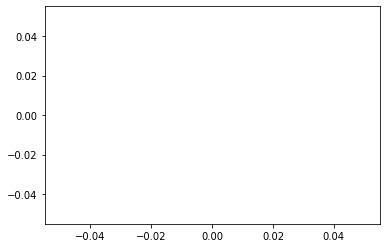

In [18]:
plt.plot(test_ls)
plt.show()